In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
!pip install torchvision

In [ ]:
!pip install keras

In [ ]:
import csv
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime, timedelta

**Retrieving all files from Directory**

In [ ]:
import os
SITE_NAME = "NEON.D01.HARV.DP1.00033"

In [ ]:
def list_files(filepath, filetype):
    paths = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if file.lower().endswith(filetype.lower()):
                paths.append(os.path.join(root, file))
    return paths

# # List to store all image files
# all_img_files = []

# # Loop through each year and append files to the list
# for year in range(2017, 2022):
#     img_files = list_files(f'/content/drive/MyDrive/Phenocam Prediction/phenocamdata/{SITE_NAME}/{year}', ".jpg")
#     img_files.sort()
#     all_img_files.extend(img_files)

# # all_img_files now contains image files from 2017 to 2021
# all_img_files

**Data Preprocessing**

In [ ]:
def load_and_preprocess_images(image_files):
    images = []

    for img_path in image_files:
        img = cv2.imread(img_path)

        if img is None:
            continue

        new_height = 224
        aspect_ratio = img.shape[1] / img.shape[0]
        new_width = int(new_height * aspect_ratio)
        img_resized = cv2.resize(img, (new_width, new_height))
        img_normalized = img_resized / 255.0

        images.append(img_normalized)

    return np.array(images)

# List to store all image files for years 2017 to 2021
all_img_files = []
for year in range(2017, 2022):
    img_files = list_files(f'/content/drive/MyDrive/Phenocam Prediction/phenocamdata/{SITE_NAME}/{year}', ".jpg")
    img_files.sort()
    all_img_files.extend(img_files)

# Load and preprocess the images
processed_images = load_and_preprocess_images(all_img_files)

# Save processed images using numpy
np.save('/content/drive/MyDrive/Phenocam Prediction/phenocamdata/processed_images.npy', processed_images)

**GCC AND RCC**

In [ ]:
# Function to get the green mask at the beginning of the year
def get_begin_mask(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, (11, 16, 39), (114, 134, 104))
    return mask

In [ ]:
# Function to get the green mask at mid-year
def get_mid_mask(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, (21, 10, 0), (110, 255, 173))
    return mask

In [ ]:
# Function to get the situated area mask --ROI
def get_situated_area(begin_mask, mid_mask):
    situated_area = cv2.bitwise_xor(begin_mask, mid_mask)
    return situated_area

In [ ]:
# Function to calculate GCC and RCC for the situated area
def calculate_gcc_rcc(image_path, situated_area):
    cur_img = cv2.imread(image_path)
    cur_img_rgb = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
    cur_img_after_mask = cv2.bitwise_and(cur_img_rgb, cur_img_rgb, mask=situated_area)
    red = np.sum(cur_img_after_mask[:,:,0])
    green = np.sum(cur_img_after_mask[:,:,1])
    blue = np.sum(cur_img_after_mask[:,:,2])
    gcc = green / (green + red + blue)
    rcc = red / (red + green + blue)
    return gcc, rcc

In [ ]:
# Example usage
begin_img = img_files[0]  # Set the image you want at the beginning
mid_img = img_files[len(img_files) // 2]  # Set the image you want at mid-year

# Get masks
begin_mask = get_begin_mask(begin_img)
mid_mask = get_mid_mask(mid_img)
situated_area = get_situated_area(begin_mask, mid_mask)

# Calculate GCC and RCC over time for the situated area
gcc_over_time = []
rcc_over_time = []

for image_name in img_files:
    gcc_value, rcc_value = calculate_gcc_rcc(image_name, situated_area)
    gcc_over_time.append(gcc_value)
    rcc_over_time.append(rcc_value)

In [ ]:
print(gcc_over_time[0])
print(rcc_over_time[0])

0.33255837872176935
0.4065904857119881


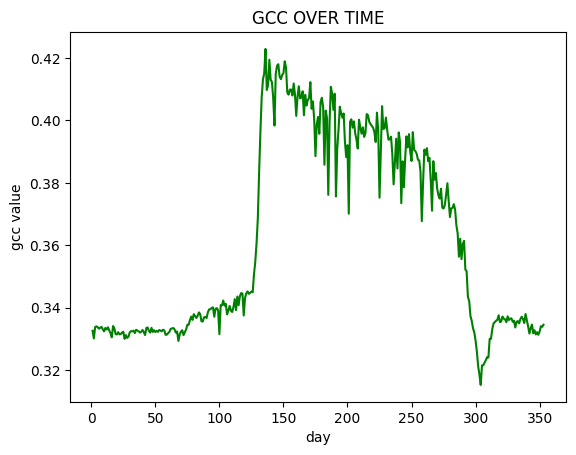

In [ ]:
plt.title("GCC OVER TIME")
plt.xlabel("day")
plt.ylabel("gcc value")
plt.plot(np.arange(1,len(img_files)+1), gcc_over_time, color="green")
plt.show()

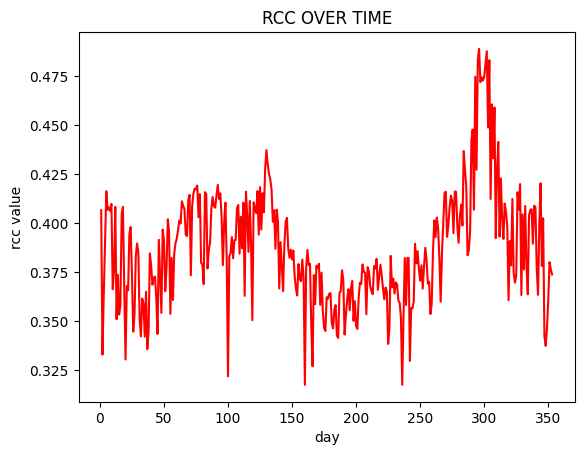

In [ ]:
plt.title("RCC OVER TIME")
plt.xlabel("day")
plt.ylabel("rcc value")
plt.plot(np.arange(1,len(img_files)+1), rcc_over_time, color="red")
plt.show()

In [ ]:
import numpy as np

def label_leaf_dates(gcc_curve, rcc_curve, sos_gcc_threshold=0.1, eos_gcc_threshold=0.9, rcc_threshold=0.5):
    """
    Label leaf growing dates based on GCC and RCC curves.

    Parameters:
    - gcc_curve: List or array containing GCC values over time.
    - rcc_curve: List or array containing RCC values over time.
    - sos_gcc_threshold: Threshold for Start of Season based on GCC (default is 0.1).
    - eos_gcc_threshold: Threshold for End of Season based on GCC (default is 0.9).
    - rcc_threshold: Threshold for labeling based on RCC (default is 0.5).

    Returns:
    - sos_index: Index of Start of Season.
    - eos_index: Index of End of Season.
    """
    # Convert curves to NumPy arrays
    gcc_curve = np.array(gcc_curve)
    rcc_curve = np.array(rcc_curve)

    # Label based on GCC
    sos_gcc_index = np.argmax(gcc_curve > sos_gcc_threshold)
    eos_gcc_index = np.argmax(gcc_curve > eos_gcc_threshold)

    # Label based on RCC
    leaf_activity_indices = np.where(rcc_curve > rcc_threshold)[0]

    # Find the intersection of GCC and RCC labels
    common_indices = np.intersect1d(leaf_activity_indices, np.arange(sos_gcc_index, eos_gcc_index + 1))

    if common_indices.size > 0:
        sos_index = common_indices[0]
        eos_index = common_indices[-1]
    else:
        # No common indices, fallback to GCC labels
        sos_index = sos_gcc_index
        eos_index = eos_gcc_index

    return sos_index, eos_index

# Label leaf growing dates
sos_index, eos_index = label_leaf_dates(gcc_over_time, rcc_over_time)

# Print or use sos_index and eos_index as needed
print("Start of Season Index:", sos_index)
print("End of Season Index:", eos_index)
print("GCC Over Time:", gcc_over_time)
print("RCC Over Time:", rcc_over_time)
print(type(gcc_over_time))

Start of Season Index: 0
End of Season Index: 0
GCC Over Time: [0.33255837872176935, 0.33009869808112924, 0.33374124680642137, 0.3339611153356082, 0.3337098407986074, 0.3332362835418835, 0.33352516144347644, 0.3338115577617854, 0.33299505186340445, 0.33236115878457706, 0.33344495847859706, 0.3329481045839357, 0.33368377879918654, 0.3326423700393264, 0.33179226848816984, 0.3304465863327932, 0.33407889635826926, 0.3333255879400136, 0.331458823590844, 0.3313876664797337, 0.3321060008597501, 0.3314189720492646, 0.33147986378499905, 0.3319688084599197, 0.33222933534379295, 0.32996471211302764, 0.3311530533989808, 0.3302696079382914, 0.33065729029149904, 0.3320338641419009, 0.33243372072735405, 0.3323430832830166, 0.33261561232526327, 0.3318007060732895, 0.3328708433847894, 0.3326312393930533, 0.33236896919866904, 0.3319859796699272, 0.33224760151889793, 0.33279412213483206, 0.3321103671563301, 0.33117664253511153, 0.33345941372498955, 0.3336065835605385, 0.33250668315676746, 0.3319593151552

**Labelling Analysis:**

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Phenocam Prediction/labeled_data.csv'
data = pd.read_csv(file_path)
data.head()

,ImageID,Filename,Date,GCC,Label,DaysSinceSOS
0,1,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-01,0.331290,Leaf Growth,1
1,2,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-02,0.333346,Leaf Growth,2
2,3,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-03,0.333678,Leaf Growth,3
3,4,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-04,0.333516,Leaf Growth,4
4,5,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-05,0.332612,Leaf Growth,5


In [ ]:
# Filtering data for the two labels: 'Dormancy' and 'Leaf Growth'
dormancy_data = data[data['Label'] == 'Dormancy']
dormancy_data.head()

,ImageID,Filename,Date,GCC,Label,DaysSinceSOS
124,125,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-05-21,0.406200,Dormancy,141
125,126,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-05-22,0.408141,Dormancy,142
126,127,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-05-23,0.408565,Dormancy,143
127,128,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-05-24,0.413364,Dormancy,144
128,129,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-05-25,0.392048,Dormancy,145


In [ ]:
leaf_growth_data = data[data['Label'] == 'Leaf Growth']
leaf_growth_data.head()

,ImageID,Filename,Date,GCC,Label,DaysSinceSOS
0,1,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-01,0.331290,Leaf Growth,1
1,2,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-02,0.333346,Leaf Growth,2
2,3,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-03,0.333678,Leaf Growth,3
3,4,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-04,0.333516,Leaf Growth,4
4,5,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-05,0.332612,Leaf Growth,5


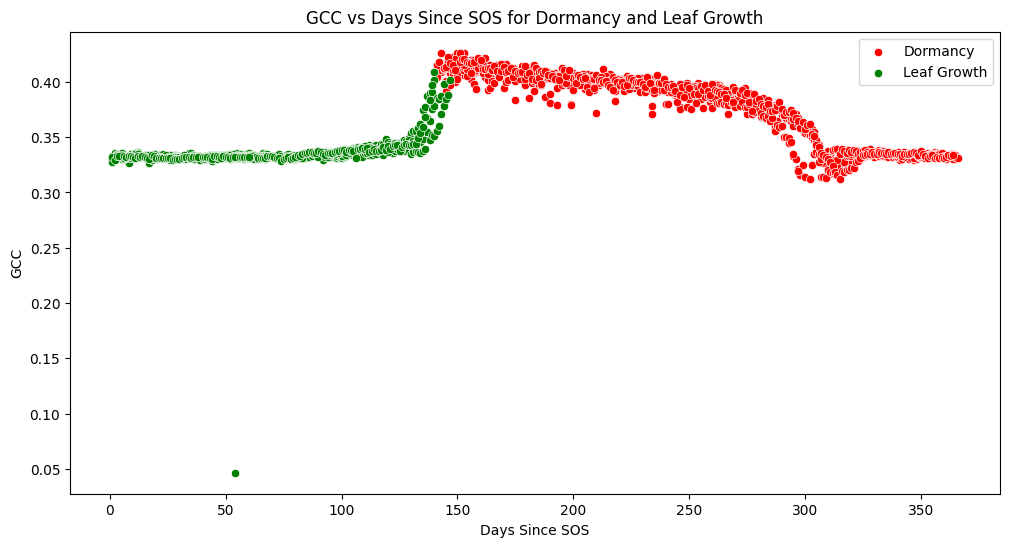

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting GCC vs DaysSinceSOS for 'Dormancy' and 'Leaf Growth'
plt.figure(figsize=(12, 6))
sns.scatterplot(x='DaysSinceSOS', y='GCC', data=dormancy_data, label='Dormancy', color='red')
sns.scatterplot(x='DaysSinceSOS', y='GCC', data=leaf_growth_data, label='Leaf Growth', color='green')
plt.title('GCC vs Days Since SOS for Dormancy and Leaf Growth')
plt.xlabel('Days Since SOS')
plt.ylabel('GCC')
plt.legend()
plt.show()

**Model Building**

In [ ]:
pip install tensorflow numpy pandas

In [ ]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

**CNNR**

Importing Necessary Libraries:

In [ ]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Phenocam Prediction/labeled_data.csv'
data = pd.read_csv(file_path)
data.head()

,ImageID,Filename,Date,GCC,Label,DaysSinceSOS
0,1,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-01,0.331290,Leaf Growth,1
1,2,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-02,0.333346,Leaf Growth,2
2,3,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-03,0.333678,Leaf Growth,3
3,4,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-04,0.333516,Leaf Growth,4
4,5,/content/drive/MyDrive/Phenocam Prediction/phe...,2017-01-05,0.332612,Leaf Growth,5


Preprocessing, Model Definition, and Training:

In [ ]:
def load_and_preprocess_images(image_files):
    images = []

    for img_path in image_files:
        img = cv2.imread(img_path)

        if img is None:
            continue

        # Resize the image to 224x224 and normalize
        img_resized = cv2.resize(img, (224, 224))
        img_normalized = img_resized / 255.0

        images.append(img_normalized)

    return np.array(images)

# Assuming all_img_files is a list of image file paths
processed_images = load_and_preprocess_images(all_img_files)
y = data['DaysSinceSOS'].values[:len(processed_images)]

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentation to training data only
X_train, X_val, y_train, y_val = train_test_split(processed_images, y, test_size=0.2, random_state=42)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [ ]:
# Define and compile the CNN model with modifications
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Output layer for regression
])


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [ ]:
# Implement a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [ ]:
# Train the model with early stopping and learning rate scheduler
history = model.fit(
    train_generator,  # Use the data generator
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the model
val_loss, val_rmse = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss, "Validation RMSE:", val_rmse)

Epoch 1/50
38/38 [==============================] - 14s 302ms/step - loss: 22503.6270 - root_mean_squared_error: 150.0121 - val_loss: 36715.8203 - val_root_mean_squared_error: 191.6137 - lr: 1.0000e-04
Epoch 2/50
38/38 [==============================] - 11s 289ms/step - loss: 13628.2822 - root_mean_squared_error: 116.7402 - val_loss: 31900.4297 - val_root_mean_squared_error: 178.6069 - lr: 1.0000e-04
Epoch 3/50
38/38 [==============================] - 11s 288ms/step - loss: 12697.7939 - root_mean_squared_error: 112.6845 - val_loss: 28007.7031 - val_root_mean_squared_error: 167.3550 - lr: 1.0000e-04
Epoch 4/50
38/38 [==============================] - 11s 297ms/step - loss: 12429.7705 - root_mean_squared_error: 111.4889 - val_loss: 21472.9355 - val_root_mean_squared_error: 146.5365 - lr: 1.0000e-04
Epoch 5/50
38/38 [==============================] - 11s 293ms/step - loss: 12078.7910 - root_mean_squared_error: 109.9035 - val_loss: 21830.6738 - val_root_mean_squared_error: 147.7521 - lr: 1

In [ ]:
# Predicting on validation set
y_val_pred = model.predict(X_val)

15/15 [==============================] - 0s 10ms/step


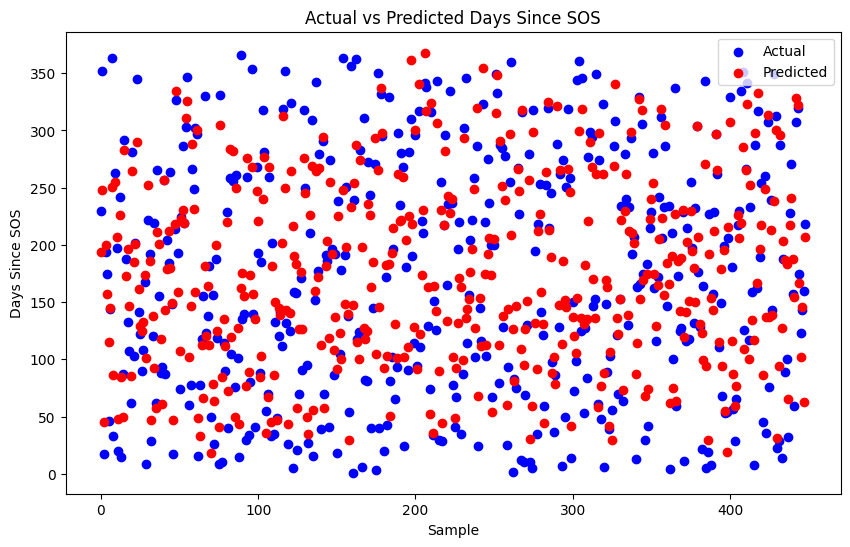

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_val)), y_val, color='blue', label='Actual')
plt.scatter(range(len(y_val_pred)), y_val_pred.flatten(), color='red', label='Predicted')
plt.title('Actual vs Predicted Days Since SOS')
plt.xlabel('Sample')
plt.ylabel('Days Since SOS')
plt.legend()
plt.show()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Predict "Days Since SOS" for a given image
def predict_days_since_sos(image_path, model):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224)) / 255.0
    prediction = model.predict(np.array([img_resized]))
    return prediction[0][0]

In [ ]:
def display_images(data, initial_date_str, model):
    # Convert the initial date string to datetime
    initial_date = pd.to_datetime(initial_date_str)

    # Check if the initial date exists in the dataset
    if not any(data['Date'] == initial_date):
        print(f"Initial date {initial_date} not found in data.")
        return

    initial_index = data[data['Date'] == initial_date].index[0]
    initial_image_path = data.loc[initial_index, 'Filename']

    # Calculate the actual and predicted future dates
    actual_date_plus_10 = initial_date + timedelta(days=10)
    predicted_days = predict_days_since_sos(initial_image_path, model)
    predicted_date_plus_10 = initial_date + timedelta(days=int(predicted_days))

    # Display the images
    plt.figure(figsize=(15, 5))

    # Function to display individual images
    def display_individual_image(image_path, title, subplot_pos):
        plt.subplot(1, 3, subplot_pos)
        try:
            image = Image.open(image_path)
            plt.imshow(image)
            plt.title(title)
        except FileNotFoundError:
            plt.text(0.5, 0.5, 'Image not found', ha='center', va='center')
        plt.axis('off')

    # Display initial, actual, and predicted images
    display_individual_image(initial_image_path, f'Initial Image on {initial_date.strftime("%Y-%m-%d")}', 1)
    display_individual_image(data.loc[data['Date'] == actual_date_plus_10, 'Filename'].values[0], f'Actual Image after 10 days', 2)
    display_individual_image(data.loc[data['Date'] == predicted_date_plus_10, 'Filename'].values[0], f'Predicted Image after {int(predicted_days)} days', 3)

    plt.tight_layout()
    plt.show()


**LSTM**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [ ]:
# Drop NaN values
data = data.dropna()

# Feature engineering: Convert 'Date' to a datetime object and extract more features
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfYear'] = data['Date'].dt.dayofyear

# Normalize the GCC values and DayOfYear
scaler_gcc = MinMaxScaler()
scaler_day_of_year = MinMaxScaler()
data['Normalized_GCC'] = scaler_gcc.fit_transform(data[['GCC']])
data['Normalized_DayOfYear'] = scaler_day_of_year.fit_transform(data[['DayOfYear']])

# Create sequences for LSTM
def create_sequences(data, N):
    X, y = [], []
    for i in range(len(data) - N):
        X.append(data[['Normalized_GCC', 'Normalized_DayOfYear']].iloc[i:i+N].values)
        y.append(data['DaysSinceSOS'].iloc[i+N])
    return np.array(X), np.array(y)

N = 10  # Number of days to look back
X, y = create_sequences(data, N)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(N, 2), return_sequences=True),
    Dropout(0.4),
    LSTM(64, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

# Compile the model with a custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[rmse])

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_rmse', factor=0.2, patience=10, verbose=1, min_lr=0.0001)

In [ ]:
# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_rmse = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Loss: {val_loss}, Validation RMSE: {val_rmse}')

Epoch 1/200
43/43 [==============================] - 5s 44ms/step - loss: 29319.7871 - rmse: 160.0182 - val_loss: 2239.6868 - val_rmse: 46.1693 - lr: 0.0010
Epoch 2/200
43/43 [==============================] - 1s 30ms/step - loss: 4452.2988 - rmse: 64.9406 - val_loss: 1903.2723 - val_rmse: 41.8081 - lr: 0.0010
Epoch 3/200
43/43 [==============================] - 1s 30ms/step - loss: 3674.2676 - rmse: 58.3859 - val_loss: 1586.3766 - val_rmse: 35.3969 - lr: 0.0010
Epoch 4/200
43/43 [==============================] - 1s 29ms/step - loss: 4019.3784 - rmse: 59.9896 - val_loss: 1725.3206 - val_rmse: 39.1123 - lr: 0.0010
Epoch 5/200
43/43 [==============================] - 1s 28ms/step - loss: 4250.4639 - rmse: 61.8362 - val_loss: 3409.1470 - val_rmse: 57.8287 - lr: 0.0010
Epoch 6/200
43/43 [==============================] - 1s 28ms/step - loss: 4040.2795 - rmse: 59.7830 - val_loss: 3038.1565 - val_rmse: 54.4655 - lr: 0.0010
Epoch 7/200
43/43 [==============================] - 1s 28ms/step - 

In [ ]:
# Predicting on validation set
y_val_pred_LSTM = model.predict(X_val)

11/11 [==============================] - 0s 9ms/step


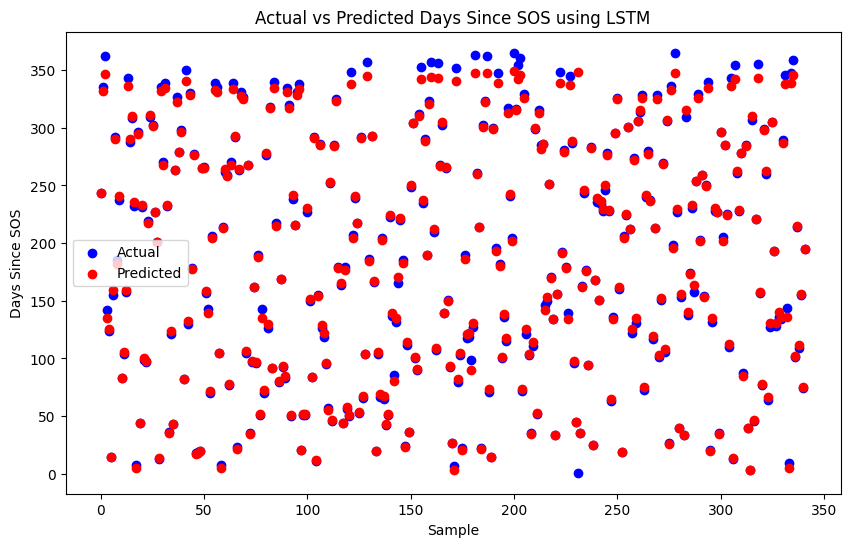

In [ ]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_val)), y_val, color='blue', label='Actual')
plt.scatter(range(len(y_val_pred)), y_val_pred.flatten(), color='red', label='Predicted')
plt.title('Actual vs Predicted Days Since SOS using LSTM')
plt.xlabel('Sample')
plt.ylabel('Days Since SOS')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [ ]:
# Ensure 'Date' is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
# Function to retrieve the image path for a given index in the dataframe
def get_image_path(df, index):
    if index < len(df):
        return df.iloc[index]['Filename']
    else:
        return None

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
from datetime import timedelta

In [ ]:
# Function to display an image from a given path
def display_image(image_path, title):
    if image_path:
        try:
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(title)
            plt.axis('off')
        except FileNotFoundError:
            plt.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
            plt.title(title)
            plt.axis('off')

In [ ]:
# Select a random date from the dataset
random_start_index = random.randint(0, len(data) - N - 10)
selected_date = data.iloc[random_start_index + N - 1]['Date']

In [ ]:
# Predict the "Days Since SOS" for this sequence
selected_sequence = X[random_start_index:random_start_index + 1]  # Select the sequence
predicted_days_since_sos = model.predict(selected_sequence)
predicted_days_since_sos_whole = int(np.round(predicted_days_since_sos[0][0]))

1/1 [==============================] - 0s 22ms/step


In [ ]:
# Calculate the actual and predicted dates
actual_date_plus_10 = selected_date + timedelta(days=10)
predicted_date = selected_date + timedelta(days=predicted_days_since_sos_whole)

In [ ]:
# Retrieve the image paths
initial_image_path = get_image_path(data, random_start_index + N - 1)
actual_indices = data.index[data['Date'] == actual_date_plus_10]
actual_image_path_10_days = get_image_path(data, actual_indices[0]) if len(actual_indices) > 0 else None
predicted_indices = data.index[data['Date'] == predicted_date]
predicted_image_path = get_image_path(data, predicted_indices[0]) if len(predicted_indices) > 0 else None

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import timedelta
import numpy as np
import pandas as pd
import random

In [ ]:
# Function to display the image details
def display_image_details(data, index, title):
    if index is not None and index < len(data):
        image_path = data.iloc[index]['Filename']
        image_date = data.iloc[index]['Date']
        image_label = data.iloc[index]['DaysSinceSOS']
        image_gcc = data.iloc[index]['GCC']

        # Display the image
        try:
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(f"{title}\nDate: {image_date.strftime('%Y-%m-%d')}\nDays Since SOS: {image_label}\nGCC: {image_gcc:.4f}")
            plt.axis('off')
        except FileNotFoundError:
            plt.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
            plt.title(title)
            plt.axis('off')
    else:
        # Handle cases where the index is not valid
        plt.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center')
        plt.title(title)
        plt.axis('off')

# Display the images with details
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

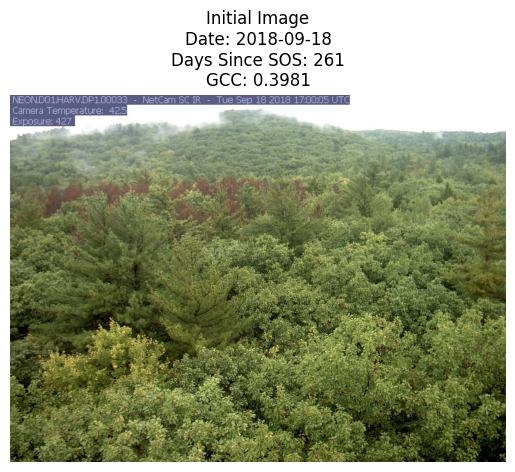

In [ ]:
# Initial image
initial_index = random_start_index + N - 1
display_image_details(data, initial_index, 'Initial Image', )

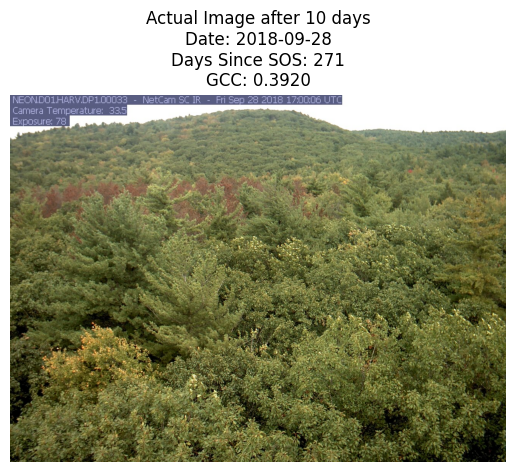

In [ ]:
# Actual image after 10 days
actual_index = data.index[data['Date'] == actual_date_plus_10][0] if len(actual_indices) > 0 else None
display_image_details(data, actual_index, 'Actual Image after 10 days')

In [ ]:
# Predicted image after predicted days
# predicted_index = data.index[data['Date'] == predicted_date][0] if len(predicted_indices) > 0 else None
# display_image_details(data, predicted_index, 'Predicted Image')

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Ensure 'Date' is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Function to print image details
def print_image_details(data, index, title):
    if index is not None and index < len(data):
        image_path = data.iloc[index]['Filename']
        image_date = data.iloc[index]['Date']
        image_label = data.iloc[index]['DaysSinceSOS']
        image_gcc = data.iloc[index]['GCC']

        print(f"{title}:")
        print(f"  Filename: {image_path}")
        print(f"  Date: {image_date.strftime('%Y-%m-%d')}")
        print(f"  Days Since SOS: {image_label}")
        print(f"  GCC: {image_gcc:.4f}")
        print()
    else:
        print(f"{title}: Data not available\n")

In [ ]:
# Select a random date from the dataset
random_start_index = random.randint(0, len(data) - N - 10)
selected_date = data.iloc[random_start_index + N - 1]['Date']

# Predict the "Days Since SOS" for this sequence
selected_sequence = X[random_start_index:random_start_index + 1]  # Select the sequence
predicted_days_since_sos = model.predict(selected_sequence)
predicted_days_since_sos_whole = int(np.round(predicted_days_since_sos[0][0]))

# Calculate the actual and predicted dates
actual_date_plus_10 = selected_date + timedelta(days=10)
predicted_date = selected_date + timedelta(days=predicted_days_since_sos_whole)

1/1 [==============================] - 0s 23ms/step


In [ ]:
# Retrieve the indices
initial_index = random_start_index + N - 1
actual_indices = data.index[data['Date'] == actual_date_plus_10]
actual_index = actual_indices[0] if len(actual_indices) > 0 else None
predicted_indices = data.index[data['Date'] == predicted_date]
predicted_index = predicted_indices[0] if len(predicted_indices) > 0 else None

In [ ]:
# Print the details
print_image_details(data, initial_index, 'Initial Image')
print_image_details(data, actual_index, 'Actual Image after 10 days')
print_image_details(data, predicted_index, 'Predicted Image after predicted days')

Initial Image:
  Filename: /content/drive/MyDrive/Phenocam Prediction/phenocamdata/NEON.D01.HARV.DP1.00033/2019/12/NEON.D01.HARV.DP1.00033_2019_12_16_120005.jpg
  Date: 2019-12-16
  Days Since SOS: 349
  GCC: 0.3328

Actual Image after 10 days:
  Filename: /content/drive/MyDrive/Phenocam Prediction/phenocamdata/NEON.D01.HARV.DP1.00033/2019/12/NEON.D01.HARV.DP1.00033_2019_12_26_120005.jpg
  Date: 2019-12-26
  Days Since SOS: 359
  GCC: 0.3340

Predicted Image after predicted days:
  Filename: /content/drive/MyDrive/Phenocam Prediction/phenocamdata/NEON.D01.HARV.DP1.00033/2020/11/NEON.D01.HARV.DP1.00033_2020_11_20_120005.jpg
  Date: 2020-11-20
  Days Since SOS: 325
  GCC: 0.3379



BiDirectional LSTM:

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [ ]:
# Drop NaN values
data = data.dropna()

# Feature engineering: Convert 'Date' to a datetime object and extract more features
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfYear'] = data['Date'].dt.dayofyear

# Normalize the GCC values and DayOfYear
scaler_gcc = MinMaxScaler()
scaler_day_of_year = MinMaxScaler()
data['Normalized_GCC'] = scaler_gcc.fit_transform(data[['GCC']])
data['Normalized_DayOfYear'] = scaler_day_of_year.fit_transform(data[['DayOfYear']])

# Create sequences
def create_sequences(data, N):
    X, y = [], []
    for i in range(len(data) - N):
        X.append(data[['Normalized_GCC', 'Normalized_DayOfYear']].iloc[i:i+N].values)
        y.append(data['DaysSinceSOS'].iloc[i+N])
    return np.array(X), np.array(y)

N = 10  # Number of days to look back
X, y = create_sequences(data, N)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
# Build the Bidirectional LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(N, 2)),
    Dropout(0.4),
    Bidirectional(LSTM(64, activation='relu')),
    Dropout(0.4),
    Dense(1)
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[rmse])

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_rmse', factor=0.2, patience=10, verbose=1, min_lr=0.0001)

In [ ]:
# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/200
43/43 [==============================] - 9s 73ms/step - loss: 23083.1895 - rmse: 137.5028 - val_loss: 1853.8661 - val_rmse: 41.8858 - lr: 0.0010
Epoch 2/200
43/43 [==============================] - 2s 58ms/step - loss: 3172.2236 - rmse: 52.7987 - val_loss: 2246.2883 - val_rmse: 46.6688 - lr: 0.0010
Epoch 3/200
43/43 [==============================] - 3s 62ms/step - loss: 2756.0337 - rmse: 50.4005 - val_loss: 1869.9346 - val_rmse: 42.2901 - lr: 0.0010
Epoch 4/200
43/43 [==============================] - 3s 60ms/step - loss: 2303.9980 - rmse: 45.8269 - val_loss: 1042.7206 - val_rmse: 27.4122 - lr: 0.0010
Epoch 5/200
43/43 [==============================] - 3s 59ms/step - loss: 2019.3479 - rmse: 41.8134 - val_loss: 732.3733 - val_rmse: 20.6577 - lr: 0.0010
Epoch 6/200
43/43 [==============================] - 3s 59ms/step - loss: 1699.7207 - rmse: 39.3667 - val_loss: 668.8359 - val_rmse: 20.7485 - lr: 0.0010
Epoch 7/200
43/43 [==============================] - 2s 58ms/step - lo

In [ ]:
# Evaluate the model on the validation set
val_loss, val_rmse = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Loss: {val_loss}, Validation RMSE: {val_rmse}')

Validation Loss: 366.8932189941406, Validation RMSE: 9.098296165466309


In [ ]:
# Predicting on validation set
y_val_pred_bidirectional = model.predict(X_val)

11/11 [==============================] - 0s 9ms/step


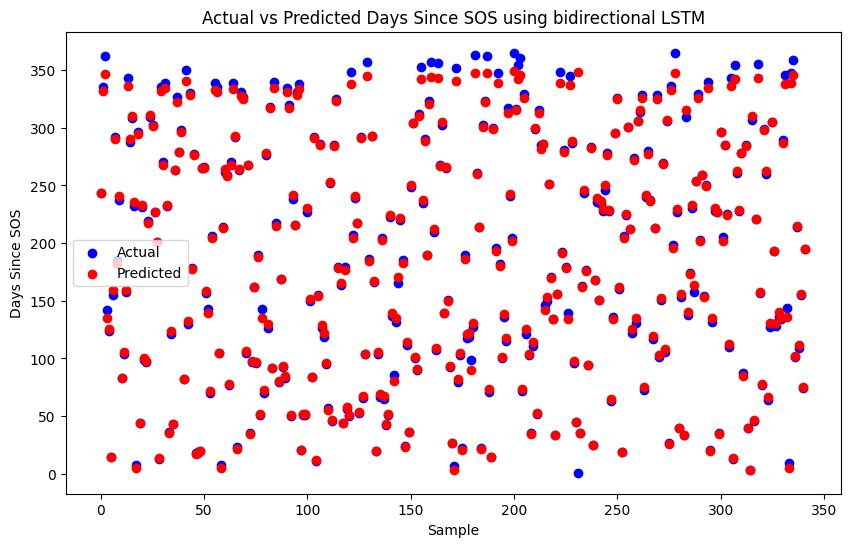

In [ ]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_val)), y_val, color='blue', label='Actual')
plt.scatter(range(len(y_val_pred)), y_val_pred.flatten(), color='red', label='Predicted')
plt.title('Actual vs Predicted Days Since SOS using bidirectional LSTM')
plt.xlabel('Sample')
plt.ylabel('Days Since SOS')
plt.legend()
plt.show()

In [ ]:
# Ensure 'Date' is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Function to retrieve the image path for a given index in the dataframe
def get_image_path(df, index):
    if index < len(df):
        return df.iloc[index]['Filename']
    else:
        return None

In [ ]:
# Function to print image details
def print_image_details(data, index, title):
    if index is not None and index < len(data):
        image_path = data.iloc[index]['Filename']
        image_date = data.iloc[index]['Date']
        image_label = data.iloc[index]['DaysSinceSOS']
        image_gcc = data.iloc[index]['GCC']

        print(f"{title}:")
        print(f"  Filename: {image_path}")
        print(f"  Date: {image_date.strftime('%Y-%m-%d')}")
        print(f"  Days Since SOS: {image_label}")
        print(f"  GCC: {image_gcc:.4f}")
        print()
    else:
        print(f"{title}: Data not available\n")

In [ ]:
# Select a random date from the dataset
random_start_index = random.randint(0, len(data) - N - 10)
selected_date = data.iloc[random_start_index + N - 1]['Date']

# Predict the "Days Since SOS" for this sequence
selected_sequence = X[random_start_index:random_start_index + 1]  # Select the sequence
predicted_days_since_sos = model.predict(selected_sequence)
predicted_days_since_sos_whole = int(np.round(predicted_days_since_sos[0][0]))

# Calculate the actual and predicted dates
actual_date_plus_10 = selected_date + timedelta(days=10)
predicted_date = selected_date + timedelta(days=predicted_days_since_sos_whole)

1/1 [==============================] - 0s 29ms/step


In [ ]:
# Retrieve the indices
initial_index = random_start_index + N - 1
actual_indices = data.index[data['Date'] == actual_date_plus_10]
actual_index = actual_indices[0] if len(actual_indices) > 0 else None
predicted_indices = data.index[data['Date'] == predicted_date]
predicted_index = predicted_indices[0] if len(predicted_indices) > 0 else None

In [ ]:
# Print the details
print_image_details(data, initial_index, 'Initial Image')
print_image_details(data, actual_index, 'Actual Image after 10 days')
print_image_details(data, predicted_index, 'Predicted Image after predicted days')

Initial Image:
  Filename: /content/drive/MyDrive/Phenocam Prediction/phenocamdata/NEON.D01.HARV.DP1.00033/2020/04/NEON.D01.HARV.DP1.00033_2020_04_18_120005.jpg
  Date: 2020-04-18
  Days Since SOS: 109
  GCC: 0.3322

Actual Image after 10 days:
  Filename: /content/drive/MyDrive/Phenocam Prediction/phenocamdata/NEON.D01.HARV.DP1.00033/2020/04/NEON.D01.HARV.DP1.00033_2020_04_28_120006.jpg
  Date: 2020-04-28
  Days Since SOS: 119
  GCC: 0.3373

Predicted Image after predicted days:
  Filename: /content/drive/MyDrive/Phenocam Prediction/phenocamdata/NEON.D01.HARV.DP1.00033/2020/08/NEON.D01.HARV.DP1.00033_2020_08_09_120005.jpg
  Date: 2020-08-09
  Days Since SOS: 222
  GCC: 0.3969



Comparison Between LSTM and bidirectional LSTM:

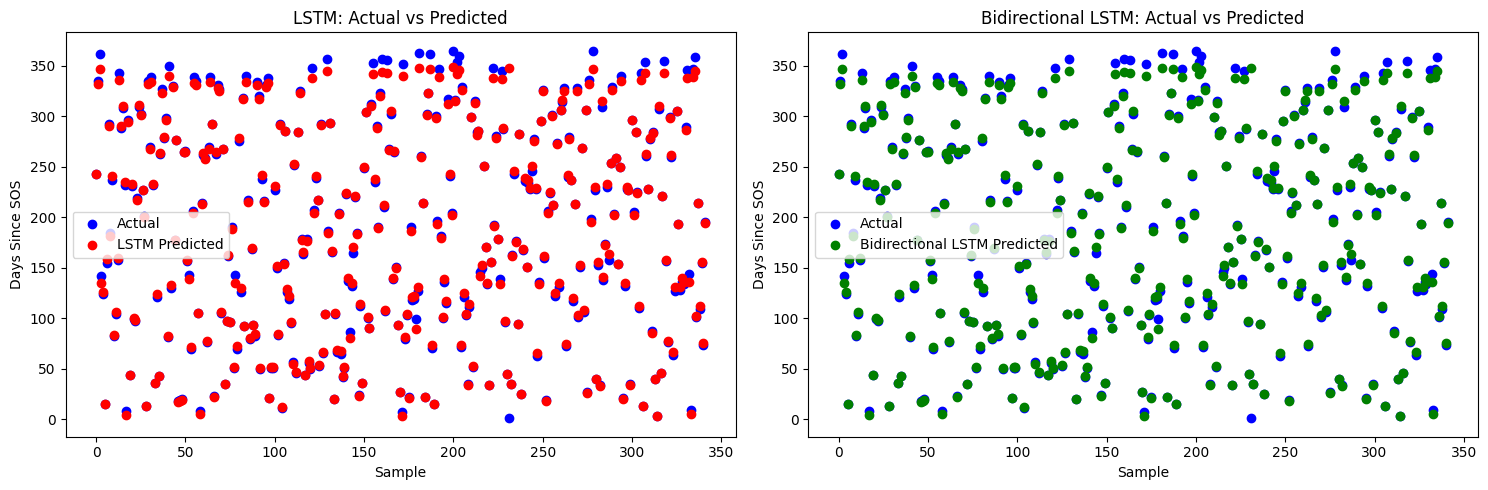

In [ ]:
plt.figure(figsize=(15, 5))

# Plot for LSTM
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val, color='blue', label='Actual')
plt.scatter(range(len(y_val_pred_LSTM)), y_val_pred_LSTM.flatten(), color='red', label='LSTM Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Days Since SOS')
plt.legend()

# Plot for Bidirectional LSTM
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_val)), y_val, color='blue', label='Actual')
plt.scatter(range(len(y_val_pred_bidirectional)), y_val_pred_bidirectional.flatten(), color='green', label='Bidirectional LSTM Predicted')
plt.title('Bidirectional LSTM: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Days Since SOS')
plt.legend()

plt.tight_layout()
plt.show()


Comparison:

### Validation Metrics:
- **LSTM Model**:
  - Validation Loss: 388.21
  - Validation RMSE: 11.45

- **Bidirectional LSTM Model**:
  - Validation Loss: 366.89
  - Validation RMSE: 9.10

The Bidirectional LSTM model has a lower validation loss and RMSE compared to the standard LSTM model. This indicates that the Bidirectional LSTM is generally making more accurate predictions.

### Visual Analysis:
From the plots, we can observe the following:

- **LSTM Plot (Red Dots)**: The predictions appear to be more scattered, with a higher concentration of points that deviate from the line of actual values. This spread suggests that while the LSTM is capturing the trend, it has a wider margin of error.

- **Bidirectional LSTM Plot (Green Dots)**: The predictions are tighter and closer to the actual points, with fewer extreme deviations. This suggests that the Bidirectional LSTM is not only capturing the general trend but also making predictions that are closer to the true values.

### Conclusion:
The Bidirectional LSTM's performance improvement can be attributed to its ability to process the sequence data in both forward and backward directions, allowing it to capture patterns that may be missed when only looking in a single direction, as with standard LSTM. However, while the Bidirectional LSTM does provide better metrics, it's essential to note a few key points:

- **Overfitting**: A lower loss on validation data is excellent, but it's crucial to ensure that the model is not overfitting.

- **Consistency**: The Bidirectional LSTM's consistent performance across different runs and datasets would be necessary to confirm its superiority.

- **Computational Cost**: Bidirectional LSTMs are more computationally intensive. If the performance gain is marginal and computational resources or inference time are critical factors, the standard LSTM might still be preferred.

- **Understanding the Data**: Knowing the nature of the data and the temporal dependencies it holds is crucial. For example, if future values are heavily dependent on past context, the Bidirectional LSTM is likely the better choice.

In summary, the Bidirectional LSTM model outperforms the standard LSTM in this case. It seems to be a more robust model for this particular task and dataset, given the lower error rates and the visual closeness of its predictions to the actual values.

**Future Scope:**
We can integrate our bidirectional LSTM model with a GAN model or VAE. In this, we can use a generative model that takes the predicted features and generates images. This could be a separate pre-trained network like a GAN or a VAE. To integrate, we would create a pipeline where the output of the LSTM directly feeds into the generative model.
Although, the limitation which I can think of is that training such an integrated system can be quite challenging as it involves backpropagating errors from the image generation part through the LSTM, which can lead to issues like vanishing or exploding gradients.